# Diffusion Model

Let's Code the Forward Process first

Beta:  [9.99999975e-05 6.04040397e-04 1.10808085e-03 1.61212124e-03
 2.11616163e-03 2.62020202e-03 3.12424242e-03 3.62828281e-03
 4.13232343e-03 4.63636359e-03 5.14040422e-03 5.64444438e-03
 6.14848500e-03 6.65252516e-03 7.15656579e-03 7.66060594e-03
 8.16464610e-03 8.66868719e-03 9.17272735e-03 9.67676751e-03
 1.01808077e-02 1.06848488e-02 1.11888889e-02 1.16929291e-02
 1.21969692e-02 1.27010103e-02 1.32050505e-02 1.37090907e-02
 1.42131317e-02 1.47171719e-02 1.52212121e-02 1.57252531e-02
 1.62292924e-02 1.67333335e-02 1.72373746e-02 1.77414138e-02
 1.82454549e-02 1.87494941e-02 1.92535352e-02 1.97575763e-02
 2.02616155e-02 2.07656566e-02 2.12696977e-02 2.17737369e-02
 2.22777780e-02 2.27818191e-02 2.32858583e-02 2.37898994e-02
 2.42939387e-02 2.47979797e-02 2.53020208e-02 2.58060601e-02
 2.63101012e-02 2.68141422e-02 2.73181815e-02 2.78222226e-02
 2.83262618e-02 2.88303029e-02 2.93343440e-02 2.98383832e-02
 3.03424243e-02 3.08464654e-02 3.13505046e-02 3.18545438e-02
 3.23585868e-02 3

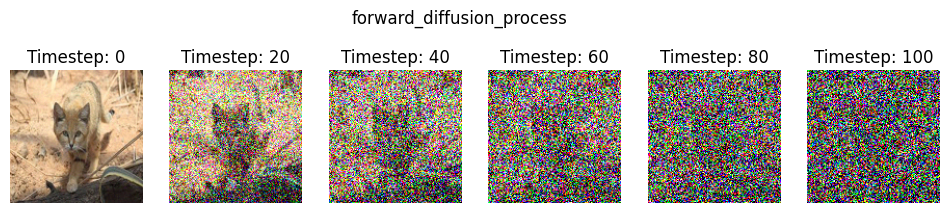

In [2]:
import os
import scipy
import urllib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def forward_diffusion_process(img_prev, beta, t):
    beta_t = beta[t].reshape(-1, 1, 1)
    
    #Calculate mean and variance
    mu = np.sqrt((1.0 - beta_t)) * img_prev
    sigma = np.sqrt(beta_t)
    
    #Obtain image at timestep t using equation
    img_t = mu + sigma * np.random.randn(*img_prev.shape)
    return img_t


#Input
img = Image.open("C:\\Users\\Tudor\\Pictures\\cats_\\ras.jpg")
IMG_SIZE = (128, 128)
img = img.resize(size=IMG_SIZE)
img_curr = np.asarray(img.copy(), dtype=np.float32) / 255.

#Parameters
timesteps = 100
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)

print("Beta: ", beta)

processed_images = []

# Run the forward process to obtain img after t timesteps
for t in range(timesteps):
    img_curr = forward_diffusion_process(img_prev=img_curr, beta=beta, t=t)
    if t%20==0 or t==timesteps - 1:
        sample = (img_curr.clip(0, 1) * 255.0).astype(np.uint8)
        processed_images.append(sample)

#Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(12, 5))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("forward_diffusion_process", y=0.75)
plt.show()

ok pretty cool